## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import math

import warnings
warnings.simplefilter('ignore')

In [2]:
cids_dmca = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # DM currency areas
cids_dmec = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']  # DM euro area countries
cids_latm = ['ARS', 'BRL', 'COP', 'CLP', 'MXN', 'PEN']  # Latam countries
cids_emea = ['HUF', 'ILS', 'PLN', 'RON', 'RUB', 'TRY', 'ZAR']  # EMEA countries
cids_emas = ['CNY', 'HKD', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'SGD', 'THB', 'TWD']  # EM Asia countries
cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids = sorted(cids_dm + cids_em)

In [15]:
from_DB = True
path_to_feather = "..//..//data//feathers//" 

xcats = ['FXCRYUSD_NSA', 'FXXRUSD_NSA', 'FXCRYEUR_NSA', 'FXXREUR_NSA']

if from_DB:
    dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                              password="l3oT7^WerjY#O!9EGqvL", database="qs_jpm_point_time")
    dfd = dbi.get_xcat(xcat=xcats, cross_section=cids, frequency="d")
    dfd.to_feather(f'{path_to_feather}dfd_fxrc_vin.ftr')
else:
    dfd = pd.read_feather(f'{path_to_feather}dfd_fxrc_vin.ftr')

In [16]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510629 entries, 0 to 510628
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cross_section     510629 non-null  object 
 1   category_code     510629 non-null  object 
 2   adjustment        510629 non-null  object 
 3   transformation    0 non-null       object 
 4   release_date      510629 non-null  object 
 5   observation_date  510629 non-null  object 
 6   value             510629 non-null  float64
 7   grading           510629 non-null  object 
dtypes: float64(1), object(7)
memory usage: 31.2+ MB


In [17]:
ind_nt = dfd['transformation'].isnull()  # index of rows that contain no transformation
dfd.loc[ind_nt, 'xcat'] = dfd['category_code'] + '_' + dfd['adjustment']  # non-transformation xcats
dfd.loc[~ind_nt, 'xcat'] = dfd['category_code'] + '_' + dfd['adjustment'] + '_' + dfd['transformation']  # full xcats
dfd['ticker'] = dfd['cross_section'] + '_' + dfd['xcat']

In [18]:
cids_exp = sorted(list(set(cids) - set(cids_dmec + ['ARS', 'HKD', 'USD'])))  # expected cids
xcats_exp = xcats # expected xcats, in most cases equal to xcats

print('Missing xcats across df: ', set(xcats_exp) - set(dfd['xcat'].unique()))  # any xcats missing
xcats_used = sorted(list(set(xcats_exp).intersection(set(dfd['xcat'].unique()))))
for xcat in xcats_used:
    cids_xcat = dfd.loc[dfd['xcat']==xcat, 'cross_section'].unique()
    print(f'Missing cids for {xcat}: ', set(cids_exp) - set(cids_xcat))  # any cross section missing?

Missing xcats across df:  set()
Missing cids for FXCRYEUR_NSA:  {'TWD', 'MYR', 'BRL', 'CAD', 'ZAR', 'KRW', 'PEN', 'CLP', 'SGD', 'JPY', 'IDR', 'COP', 'EUR', 'MXN', 'PHP', 'CNY', 'NZD', 'THB', 'AUD', 'INR', 'ILS'}
Missing cids for FXCRYUSD_NSA:  set()
Missing cids for FXXREUR_NSA:  {'TWD', 'MYR', 'BRL', 'CAD', 'ZAR', 'KRW', 'PEN', 'CLP', 'SGD', 'JPY', 'IDR', 'COP', 'EUR', 'MXN', 'PHP', 'CNY', 'NZD', 'THB', 'AUD', 'INR', 'ILS'}
Missing cids for FXXRUSD_NSA:  set()


## Functions

In [9]:
def vintage_datapoints(df, xcat, cids = None):
    """Plot bars of datapoints per vintage grade per cross section"""
    
    dfx = df[df['xcat']== xcat]
    
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    sns.set_theme(style='whitegrid')
    g = sns.catplot(data=df[df['xcat']== xcat], kind='count', hue='grading',
                    order=cids, x='cross_section', palette='dark', aspect=1.8, alpha=0.5)
    g.set_xticklabels(rotation=90, size=12)
    g.fig.suptitle(xcat, y=1.02)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

In [10]:
def countmap(df, xcat, start_year, cids=None, figsize=(12, 12), trueVin = False):
    """Visualize availability of vintages at release nearest year-end"""
    
    dfx = df[df['xcat']==xcat]
    if trueVin:
        dfx = dfx[dfx['grading'].isin(['1', '1.0', '2.2'])]
        
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
        
    dfx.loc[:, 'year'] = pd.DatetimeIndex(dfx.loc[:,'release_date']).year
    dfx = dfx[dfx.year >= start_year]

    dfxx = pd.DataFrame(columns=dfx.columns)
    for cid in cids:
        dfc = dfx.query('cross_section == @cid').reset_index(drop=True)
        releases = dfc[["year", "release_date"]].groupby("year")["release_date"].max().values  # use panda series!
        dfcx = dfc[dfc['release_date'].isin(releases)]
        dfxx = dfxx.append(dfcx)

    count_matrix = pd.crosstab(dfxx["year"], dfxx["cross_section"])  # per default crosstab counts rows
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(count_matrix, annot=True, fmt="d",
                    cmap="YlGnBu", cbar=False, linewidths=.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(xcat + ': Vintage lengths for last (available) release in year ', y = 1.1, fontsize=14)
    plt.show

In [11]:
def vintage_lengths(df, xcat, cids=None, ncols = 5):
    """Draw timelines of vintage lengths"""
    
    dfx = df[(df['xcat'] == xcat)]
    
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    dfx = dfx.loc[:, ['cross_section', 'release_date', 'observation_date']].\
            groupby(['cross_section', 'release_date']).agg('count')
    dfx.reset_index(inplace=True)
    
    fg = sns.relplot(x='release_date', y = 'observation_date', data=dfx, kind='line', col='cross_section', 
                     col_wrap=ncols, aspect = 1.5)
    (fg.set_axis_labels("Release date", "")
      .set_titles("{col_name}", size=16)
      .fig.suptitle(f'Vintage lengths of {xcat} across release time', y = 1.03, fontsize=20))
    plt.show()

In [12]:
def revlines(df, xcat, pots, cids = None, start='2000-01-01', ncols=4, size = None):
    """Visualize vintage lines for given dates"""
    
    filt1 = df['observation_date'] > pd.to_datetime(start)
    filt2 = df['xcat'] == xcat
    dfx = df[filt1 & filt2]
    
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections for {xcat}: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
        
    sns.set_style('whitegrid')
    colors = sns.color_palette("Blues", len(pots))
    nrows = math.ceil(len(cids)/ncols)
    if size is None:
        size = (16, nrows * 3)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=size)

    for i in range(len(cids)):
        cid = cids[i]
        dfc = dfx.query('cross_section == @cid')
        releases = dfc['release_date'].unique()
        selected_releases = [None] * len(pots)
        for p in range(len(pots)):  # get releases nearest and before chosen ones
            release = releases[(releases <= pd.to_datetime(pots[p]))].max()
            selected_releases[p] = release
        dfcx = dfc[dfc['release_date'].isin(selected_releases)]
        axe = axes[math.floor(i / ncols), (i % ncols)]
        sns.lineplot(data=dfcx,  x="observation_date", y="value", 
                     hue="release_date", palette=colors, ax=axe)
        axe.set(title=cid, ylabel="", xlabel="")

    plt.show()

## Availabilities

### USD returns/ carries

Missing cross sections:  set()


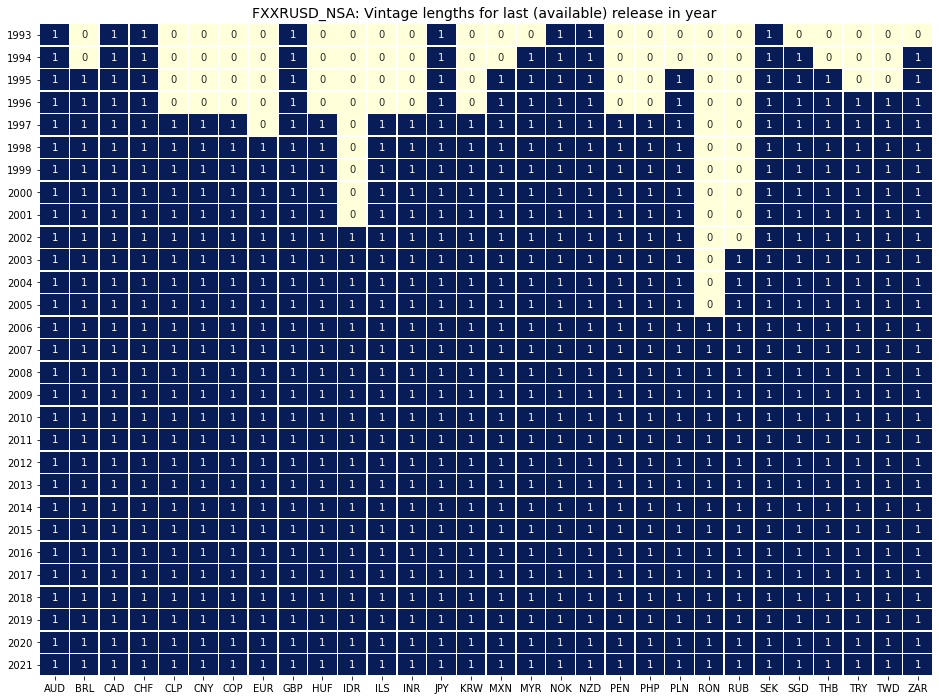

In [19]:
countmap(dfd, xcat='FXXRUSD_NSA', cids=cids_exp, start_year=1990, figsize=(16, 12))

Missing cross sections:  set()


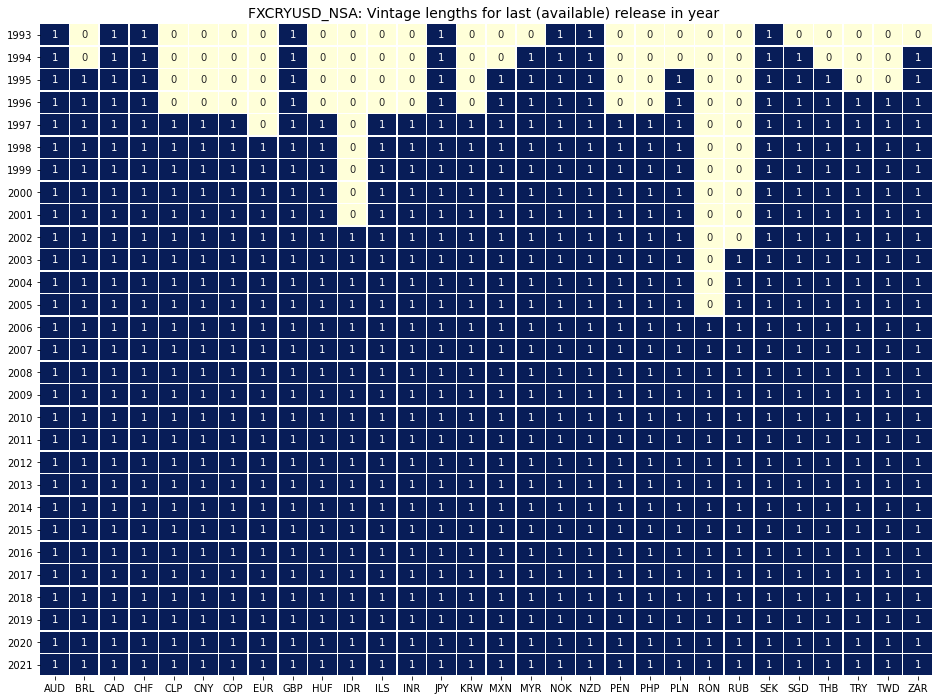

In [20]:
countmap(dfd, xcat='FXCRYUSD_NSA', cids=cids_exp, start_year=1990, figsize=(16, 12))

### EUR returns/ carries

Missing cross sections:  {'TWD', 'MYR', 'BRL', 'CAD', 'ZAR', 'KRW', 'PEN', 'CLP', 'SGD', 'JPY', 'IDR', 'COP', 'EUR', 'MXN', 'PHP', 'CNY', 'NZD', 'THB', 'AUD', 'INR', 'ILS'}


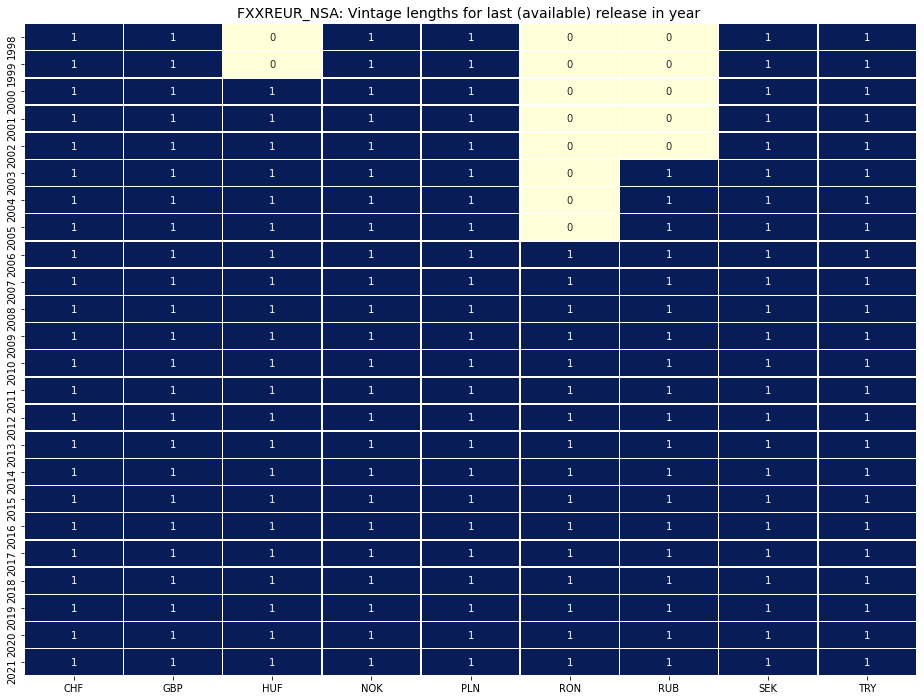

In [22]:
countmap(dfd, xcat='FXXREUR_NSA', cids=cids_exp, start_year=1990, figsize=(16, 12))

Missing cross sections:  {'TWD', 'MYR', 'BRL', 'CAD', 'ZAR', 'KRW', 'PEN', 'CLP', 'SGD', 'JPY', 'IDR', 'COP', 'EUR', 'MXN', 'PHP', 'CNY', 'NZD', 'THB', 'AUD', 'INR', 'ILS'}


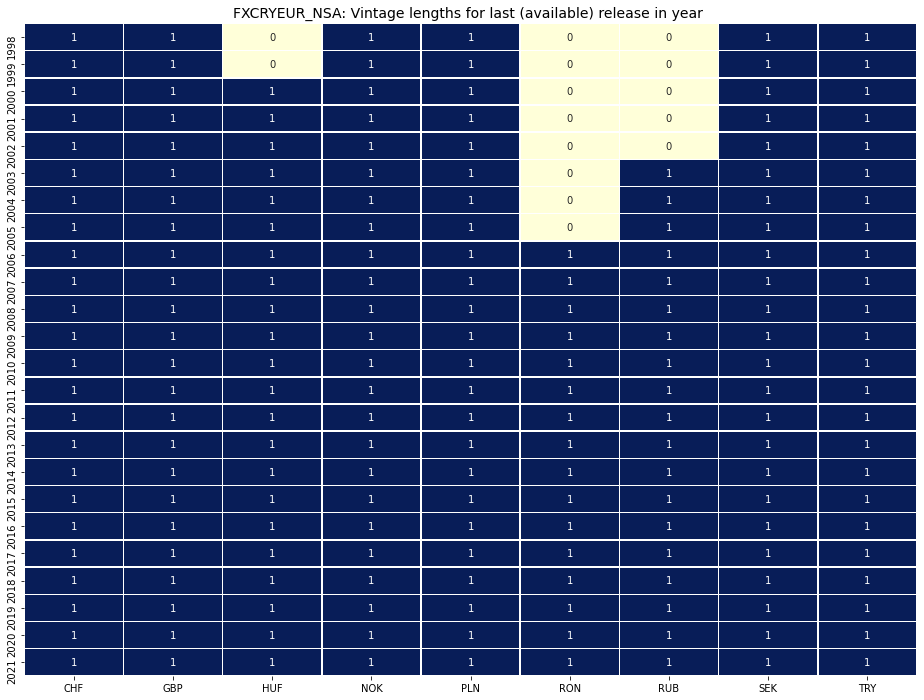

In [23]:
countmap(dfd, xcat='FXCRYEUR_NSA', cids=cids_exp, start_year=1990, figsize=(16, 12))